In [13]:
from typing import Tuple
import sys

sys.path.append("..")

import numpy as np
import torch
import seaborn as sns
from torch import nn
from torch import optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from sklearn.datasets import fetch_covtype
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from src.hooks import HookManager
from src.model.ffn import FFN
from src.utils import list_child_modules


class SampleDataset(Dataset):
    def __init__(self, features: np.ndarray, label: np.ndarray) -> None:
        super().__init__()
        self.features = features
        self.label = label
        self._scaler()

    def _scaler(self) -> None:
        mm = MinMaxScaler()
        self.features = mm.fit_transform(self.features)

    def __len__(self) -> int:
        return self.features.shape[0]

    def __getitem__(self, idx: int) -> Tuple[np.ndarray, np.ndarray]:
        return (self.features[idx, :], self.label[idx] - 1)

In [14]:
cov_type = fetch_covtype(data_home="../covertype")
X_train, X_test, y_train, y_test = train_test_split(
    cov_type.data, cov_type.target, test_size=0.2, random_state=42
)
train_dataset = SampleDataset(X_train, y_train)
test_dataset = SampleDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [3]:
model = FFN(X_train.shape[1], len(set(y_train)))

In [ ]:
print("training...")

n_epochs = 1
optimizer = optim.AdamW(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

for epoch in tqdm(range(n_epochs)):
    epoch_loss = 0
    model.train()
    for tr_x, tr_y in train_loader:
        tr_x, tr_y = (
            torch.tensor(tr_x, dtype=torch.float32),
            torch.tensor(tr_y, dtype=torch.long),
        )
        pred_tr_y = model(tr_x)
        loss = criterion(pred_tr_y, tr_y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        epoch_loss += loss.item()

    print(f"Epoch: {epoch + 1} | Loss: {epoch_loss / len(train_loader)}")

In [4]:
list_child_modules(model)

ffn.0 LayerNorm((54,), eps=1e-05, elementwise_affine=True)
ffn.1 Dropout(p=0.1, inplace=False)
ffn.2 Linear(in_features=54, out_features=512, bias=True)
ffn.3 ReLU()
ffn.4 LayerNorm((512,), eps=1e-05, elementwise_affine=True)
ffn.5 Dropout(p=0.1, inplace=False)
ffn.6 Linear(in_features=512, out_features=512, bias=True)
ffn.7 ReLU()
ffn.8 LayerNorm((512,), eps=1e-05, elementwise_affine=True)
ffn.9 Dropout(p=0.1, inplace=False)
ffn.10 Linear(in_features=512, out_features=7, bias=True)
ffn.11 Softmax(dim=1)


In [9]:
torch.save(
    model.state_dict(),
    "../model/ffn_covtype.pth",
)

In [4]:
model.load_state_dict(
    torch.load(
        "../model/ffn_covtype.pth",
        map_location=torch.device("cpu"),
        weights_only=True,
    )
)

<All keys matched successfully>

In [ ]:
print("testing...")
model.eval()
hook_mgr = HookManager()
hook_mgr.register_hooks(model, partial_matches=None)

with torch.no_grad():
    for ts_x, ts_y in test_loader:
        ts_x = torch.tensor(ts_x, dtype=torch.float32)
        ts_y = torch.tensor(ts_y, dtype=torch.long)
        pred_y_test = model(ts_x)
        break

activations = hook_mgr.get_activations()

testing...


/var/folders/5p/5d5cjs1n0sd8dhmpcjd35h0r0000gn/T/ipykernel_17687/1359222154.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ts_x = torch.tensor(ts_x, dtype=torch.float32)
/var/folders/5p/5d5cjs1n0sd8dhmpcjd35h0r0000gn/T/ipykernel_17687/1359222154.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ts_y = torch.tensor(ts_y, dtype=torch.long)


In [12]:
type(activations)

dict

<Axes: ylabel='Density'>

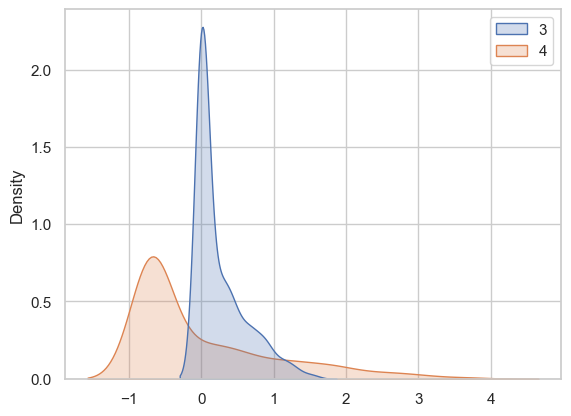

In [11]:
sns.set_style("whitegrid")
sns.set_palette("deep")
sns.set_context("notebook")

sns.kdeplot(
    {
        "3": activations["ffn.3"].cpu().numpy()[0],
        "4": activations["ffn.4"].cpu().numpy()[0],
    },
    common_norm=False,
    fill=True,
)
# import matplotlib.pyplot as plt

# plt.figure(figsize=(10, 5))
# plt.style.use("default")
# plt.scatter(
#     activations["ffn.2"].cpu().numpy()[0], activations["ffn.3"].cpu().numpy()[0]
# )

In [23]:
from src.statistics import print_summary

for k, v in activations.items():
    print_summary(k, v)


 Stats for ffn.0:
  mean: -0.0000
  std: 0.9999
  min: -0.4964
  max: 2.8709
  sparsity: 0.0000
  skewness: 1.8082
  kurtosis: 1.8572

 Stats for ffn.1:
  mean: -0.0000
  std: 0.9999
  min: -0.4964
  max: 2.8709
  sparsity: 0.0000
  skewness: 1.8082
  kurtosis: 1.8572

 Stats for ffn.2:
  mean: 0.0370
  std: 0.5705
  min: -1.6625
  max: 1.6281
  sparsity: 0.0000
  skewness: -0.1414
  kurtosis: 0.0666

 Stats for ffn.3:
  mean: 0.2477
  std: 0.3375
  min: 0.0000
  max: 1.6281
  sparsity: 0.4785
  skewness: 1.4276
  kurtosis: 1.5131

 Stats for ffn.4:
  mean: -0.0000
  std: 1.0000
  min: -0.7339
  max: 4.0894
  sparsity: 0.0000
  skewness: 1.4276
  kurtosis: 1.5131

 Stats for ffn.5:
  mean: -0.0000
  std: 1.0000
  min: -0.7339
  max: 4.0894
  sparsity: 0.0000
  skewness: 1.4276
  kurtosis: 1.5131

 Stats for ffn.6:
  mean: 0.0122
  std: 0.5600
  min: -2.0368
  max: 1.8667
  sparsity: 0.0000
  skewness: -0.1611
  kurtosis: 0.5732

 Stats for ffn.7:
  mean: 0.2250
  std: 0.3244
  min: 0.